In [45]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
import os
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import save_image

## Preprocessing - Image segmentation

In [46]:
dataset_path = '/Users/saraelgayar/Dataset/traning/set0'

In [47]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

raw_images = load_images_from_folder(dataset_path)

In [48]:
len(raw_images)

690

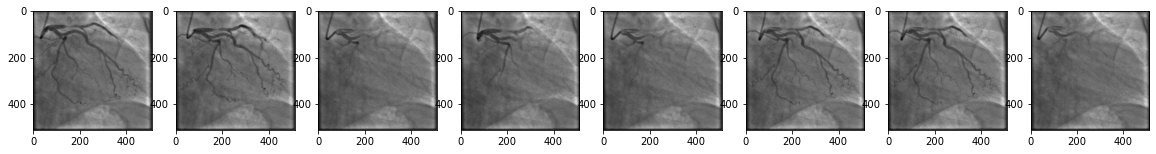

In [49]:
def show_raw_images(images):
    n = len(images)
    f = plt.figure(figsize=(20,20))
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)
    
show_raw_images(raw_images[:8])

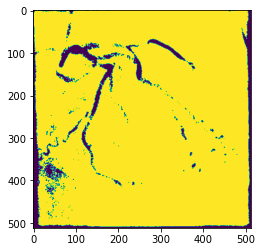

In [50]:
# NOw we need to create a mask of the artries, mask is conversion to grayscale of an image
bin_list = []
for gray_image in raw_images:
    img2gray = cv2.cvtColor(gray_image, cv2.COLOR_BGR2GRAY) 
    ret, mask = cv2.threshold(img2gray, 72, 255, cv2.THRESH_BINARY_INV)
    mask_inv = cv2.bitwise_not(mask)
    result = cv2.bitwise_and(img2gray, img2gray, mask=mask_inv)
    bin_list.append(result)
   
plt.imshow(mask_inv)

## Save preprocessed images to traning dataset folder 

In [51]:
import os
save_dataset_path = '/Users/saraelgayar/Dataset_bin/traning/set0/'
index = 0
for img in bin_list:
    cv2.imwrite('%s/%s.JPEG' % (save_dataset_path, index), img)
    index += 1


## Dataloader 

In [52]:
import torchvision.transforms.functional as F
# mean = [0.3999]
# std = [0.243]
CHANNELS_IMG = 1

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize( [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),

])


In [53]:
train_dataset_path = '/Users/saraelgayar/Dataset_bin/traning'
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform = train_transform)


In [54]:
def show_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=24, shuffle=True )
    batch = next(iter(loader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images,padding=1,normalize=True, ncol = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1, 2, 0)) ) 
    plt.title("Training Images")

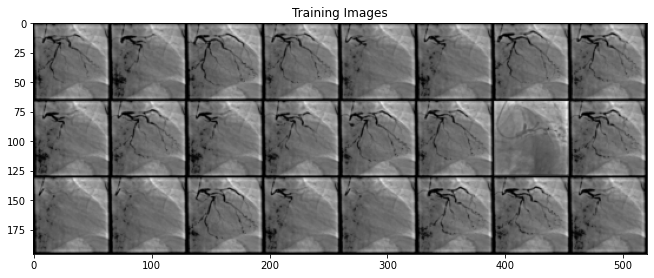

In [55]:

show_images(train_dataset)

In [56]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 30, shuffle=True)

In [57]:
next(iter(train_loader))[0].shape

torch.Size([30, 1, 64, 64])

In [58]:
len(train_loader)

25

In [59]:
#Discriminator and Generator implementation from DCGAN paper
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


In [60]:


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 2, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [61]:

def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [62]:
# Training of DCGAN network on the dataset with Discriminator and Generator 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Hyperparameters 
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.0005 #0.005  
BATCH_SIZE = 30
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 10
FEATURES_DISC = 64
FEATURES_GEN = 64

In [63]:
# pip install tensorboard

In [64]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN)#.to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC)#.to(device)
initialize_weights(gen)
initialize_weights(disc)

In [65]:

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [40]:

fixed_noise = torch.randn(30, NOISE_DIM, 1, 1)#.to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (6): Sigmoid()
  )
)

In [47]:
#pip install torchsummary

In [22]:
print(gen)

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 1, 

In [141]:
#https://androidkt.com/visualize-pytorch-model-graph-with-tensorboard/
#The summary must take the input size and batch size is set to -1 meaning any batch size we provide.

from torchsummary import summary
summary(gen, input_size = ( 100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           2,049
             Tanh-14            [-1, 1,

In [142]:
summary(disc, input_size = (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,088
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,193
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,763,585
Trainable param

In [67]:
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1)#.to(device)
        fake = gen(noise)
      
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
       
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))), max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        if (batch_idx == 0) & (epoch == 0):
            writer_fake.add_graph(gen, noise)
            writer_real.add_graph(disc, real)
        # Print losses occasionally and print to tensorboard
        if (batch_idx % 5 == 0) & (epoch % 2 == 0):
            writer_real.add_scalar("loss_disc", loss_disc, global_step=step)
            writer_real.add_scalar("loss_gen", loss_gen, global_step=step)
            print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 30 examples to tensorboard
                img_grid_real = torchvision.utils.make_grid(real[:30], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:30], normalize=True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1


Epoch [0/10] Batch 0/25                   Loss D: 0.6026, loss G: 1.2977
Epoch [0/10] Batch 5/25                   Loss D: 0.6357, loss G: 1.3430
Epoch [0/10] Batch 10/25                   Loss D: 0.9207, loss G: 2.2662
Epoch [0/10] Batch 15/25                   Loss D: 0.7777, loss G: 1.0305
Epoch [0/10] Batch 20/25                   Loss D: 0.6668, loss G: 1.0249
Epoch [2/10] Batch 0/25                   Loss D: 0.5840, loss G: 1.5341
Epoch [2/10] Batch 5/25                   Loss D: 0.6100, loss G: 2.2770
Epoch [2/10] Batch 10/25                   Loss D: 0.6140, loss G: 1.4556
Epoch [2/10] Batch 15/25                   Loss D: 0.4783, loss G: 2.3511
Epoch [2/10] Batch 20/25                   Loss D: 0.3877, loss G: 2.3835
Epoch [4/10] Batch 0/25                   Loss D: 0.5140, loss G: 2.0576
Epoch [4/10] Batch 5/25                   Loss D: 0.3239, loss G: 3.0658
Epoch [4/10] Batch 10/25                   Loss D: 0.9806, loss G: 1.8992
Epoch [4/10] Batch 15/25                   L

In [23]:
# Save generated images
#generated_dataset_path = '/Users/saraelgayar/Dataset_generated'

In [58]:
#for i in range(30):
#    save_image(fake[i], "%s/%s.jpeg" % (generated_dataset_path, i), normalize=True)

In [43]:
load_ext tensorboard

In [201]:
#pip install tensorflow

In [69]:
tensorboard --logdir logs/real

In [68]:
tensorboard --logdir logs/fake